## Creating Synthetic Training Data

In [5]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

t = np.arange(0, 50, 0.1)
y = np.sin(t)

y_all = pd.DataFrame(y, index = t)

# Splitting into training and testing data sets
# 10% of the data for the
test_split = 0.1
test_index = int(len(y_all) - np.round(len(y_all)*test_split))

train = y_all.iloc[:test_index]
test = y_all.iloc[test_index:]

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler();
scaler.fit(train);
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [7]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# define generator
length = 49 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size = batch_size)

validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length = length, batch_size = batch_size)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RNN, Dense, LSTM, LSTMCell
from tensorflow.keras.callbacks import EarlyStopping
from architectures_v1 import *

In [9]:
n_features = 1

early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

model = Sequential()
model.add(RNN(OrthogonalCell(units = 50,
                             variant = 'ct_laguerre',
                             dt = 0.1,
                            input_dims = 1) ,input_shape = (length, n_features)))
#model.add(RNN(tf.keras.layers.LSTMCell(4), input_shape = (length, n_features)))

# Final Prediction
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.summary()

model.fit_generator(generator, epochs = 200, validation_data = validation_generator, callbacks = [early_stop])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (RNN)                    (None, 50)                2711      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 2,762
Trainable params: 2,754
Non-trainable params: 8
_________________________________________________________________
Epoch 1/200
401/401 [==============================] - 8s 20ms/step - loss: 0.0254 - val_loss: 1.2914e-05
Epoch 2/200
401/401 [==============================] - 7s 18ms/step - loss: 1.0797e-04 - val_loss: 3.9143e-07
Epoch 3/200
401/401 [==============================] - 8s 19ms/step - loss: 9.7813e-05 - val_loss: 3.0230e-04
Epoch 4/200
401/401 [==============================] - 8s 19ms/step - loss: 0.0010 - val_loss: 3.2942e-05


In [10]:
n_features = 1

early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

model_trad = Sequential()
model_trad.add(RNN(tf.keras.layers.LSTMCell(units = 50), input_shape = (length, n_features)))
#model.add(RNN(tf.keras.layers.LSTMCell(4), input_shape = (length, n_features)))

# Final Prediction
model_trad.add(Dense(1))

model_trad.compile(optimizer='adam', loss='mse')

model_trad.summary()

model_trad.fit_generator(generator, epochs = 200, validation_data = validation_generator, callbacks = [early_stop])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_1 (RNN)                  (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
401/401 [==============================] - 16s 40ms/step - loss: 0.0204 - val_loss: 1.0051e-04
Epoch 2/200
401/401 [==============================] - 17s 41ms/step - loss: 3.9644e-05 - val_loss: 5.2576e-07
Epoch 3/200
401/401 [==============================] - 17s 42ms/step - loss: 9.8387e-05 - val_loss: 3.7984e-05
Epoch 4/200
401/401 [==============================] - 17s 44ms/step - loss: 6.0628e-05 -

/Users/sergio.dorado/miniconda3/envs/sd_dev_tf_1/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sergio.dorado/miniconda3/envs/sd_dev_tf_1/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


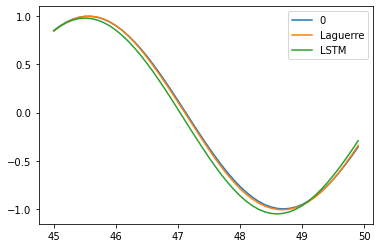

In [12]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for _ in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1: ,:],[[current_pred]], axis = 1)
    
true_predictions = scaler.inverse_transform(test_predictions)
test['Laguerre'] = true_predictions

test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for _ in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model_trad.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1: ,:],[[current_pred]], axis = 1)
    
true_predictions = scaler.inverse_transform(test_predictions)
test['LSTM'] = true_predictions
test.plot()